In [2]:
import pandas as pd

# Load the dataset
mouse_df = pd.read_csv("logger_mouseactionlog_modified.csv")

# Drop empty rows
mouse_df.dropna(how='all', inplace=True)

# Drop rows with missing essential values
essential_cols = ['id', 'action', 'coordinates', 'button', 'delta', 'distance', 'speed', 'user_id', 'timestamp']
mouse_df.dropna(subset=essential_cols, inplace=True)

# Convert timestamp
mouse_df['timestamp'] = pd.to_datetime(mouse_df['timestamp'], errors='coerce')
mouse_df.dropna(subset=['timestamp'], inplace=True)


/var/folders/xn/3p4bls9951b26kzwyk7s2_g40000gp/T/ipykernel_1838/3170299081.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  mouse_df = pd.read_csv("logger_mouseactionlog_modified.csv")


In [3]:
import numpy as np

# Step 1: Sort and reset index
mouse_df = mouse_df.sort_values(by=['user_id', 'timestamp']).reset_index(drop=True)

# Step 2: Convert timestamp to datetime (if not already)
mouse_df['timestamp'] = pd.to_datetime(mouse_df['timestamp'])

# Step 3: Detect sessions by inactivity (e.g., >5 minutes = new session)
mouse_df['time_diff'] = mouse_df.groupby('user_id')['timestamp'].diff().dt.total_seconds()
mouse_df['session_id'] = (mouse_df['time_diff'] > 300).fillna(False).cumsum()

# Step 4: Group by user-session and summarize
mouse_features = mouse_df.groupby(['user_id', 'session_id']).agg({
    'distance': ['mean', 'std', 'sum'],
    'speed': ['mean', 'std'],
    'id': 'count',
    'time_diff': ['mean', 'std', 'max']
}).reset_index()

# Flatten multi-level columns
mouse_features.columns = ['user_id', 'session_id', 'distance_mean', 'distance_std', 'distance_sum',
                          'speed_mean', 'speed_std', 'event_count',
                          'idle_mean', 'idle_std', 'idle_max']

# Add session duration (optional)
session_times = mouse_df.groupby(['user_id', 'session_id'])['timestamp'].agg(['min', 'max'])
mouse_features['session_duration_sec'] = (session_times['max'] - session_times['min']).dt.total_seconds().values

# Export if needed
mouse_features.to_csv("mouse_user_session_features.csv", index=False)

# Preview
mouse_features.head()


,user_id,session_id,distance_mean,distance_std,distance_sum,speed_mean,speed_std,event_count,idle_mean,idle_std,idle_max,session_duration_sec
0,2.0,0,0.0,0.0,0.0,0.0,0.0,18,16.579235,51.687673,215.7820,281.847
1,2.0,1,0.0,0.0,0.0,0.0,0.0,5,168.417800,353.131940,799.9730,42.116
2,2.0,2,0.0,NaN,0.0,0.0,NaN,1,609.141400,NaN,609.1414,0.000
3,2.0,3,0.0,0.0,0.0,0.0,0.0,5,120.256320,227.522683,526.5936,74.688
4,2.0,4,0.0,0.0,0.0,0.0,0.0,10,59.345300,139.913026,454.4650,138.988


In [4]:
mouse_features.describe()


,user_id,session_id,distance_mean,distance_std,distance_sum,speed_mean,speed_std,event_count,idle_mean,idle_std,idle_max,session_duration_sec
count,213.000000,213.000000,213.0,185.0,213.0,213.0,185.0,213.000000,2.100000e+02,1.820000e+02,2.100000e+02,213.000000
mean,48.399061,78.892019,0.0,0.0,0.0,0.0,0.0,13.657277,1.441275e+04,1.126377e+04,3.617801e+04,284.490061
std,23.826127,43.877107,0.0,0.0,0.0,0.0,0.0,21.872053,1.367034e+05,9.444926e+04,2.458754e+05,440.320562
min,2.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,2.702667e+00,3.775950e-01,3.567000e+00,0.000000
25%,34.000000,42.000000,0.0,0.0,0.0,0.0,0.0,2.000000,4.009591e+01,6.645391e+01,2.716718e+02,21.798000
50%,51.000000,78.000000,0.0,0.0,0.0,0.0,0.0,6.000000,1.149999e+02,1.637779e+02,5.526480e+02,105.988000
75%,67.000000,117.000000,0.0,0.0,0.0,0.0,0.0,16.000000,4.614627e+02,5.017068e+02,1.277908e+03,370.125000
max,85.000000,154.000000,0.0,0.0,0.0,0.0,0.0,181.000000,1.899514e+06,1.230829e+06,2.752239e+06,3714.507000


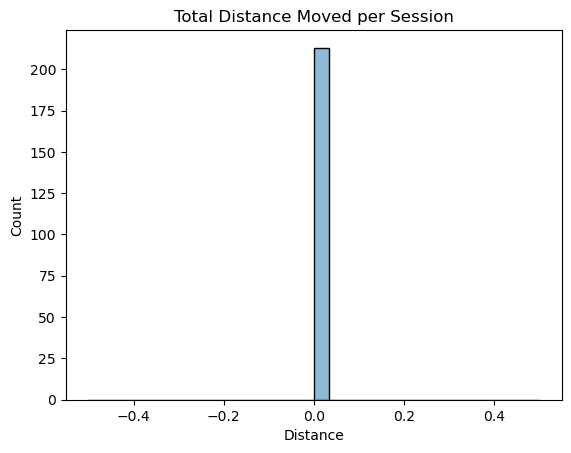

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(mouse_features['distance_sum'], bins=30, kde=True)
plt.title("Total Distance Moved per Session")
plt.xlabel("Distance")
plt.ylabel("Count")
plt.show()


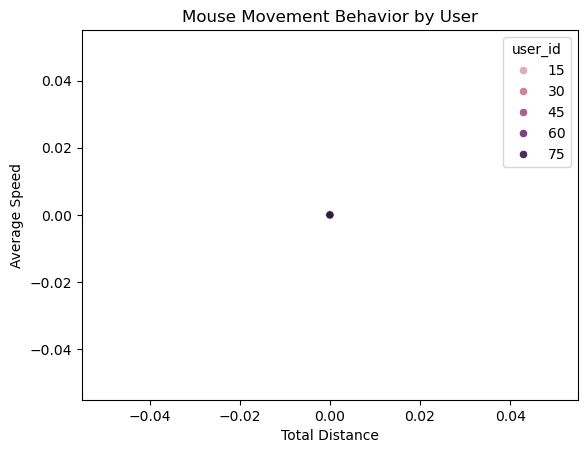

In [6]:
sns.scatterplot(data=mouse_features, x='distance_sum', y='speed_mean', hue='user_id')
plt.title("Mouse Movement Behavior by User")
plt.xlabel("Total Distance")
plt.ylabel("Average Speed")
plt.show()


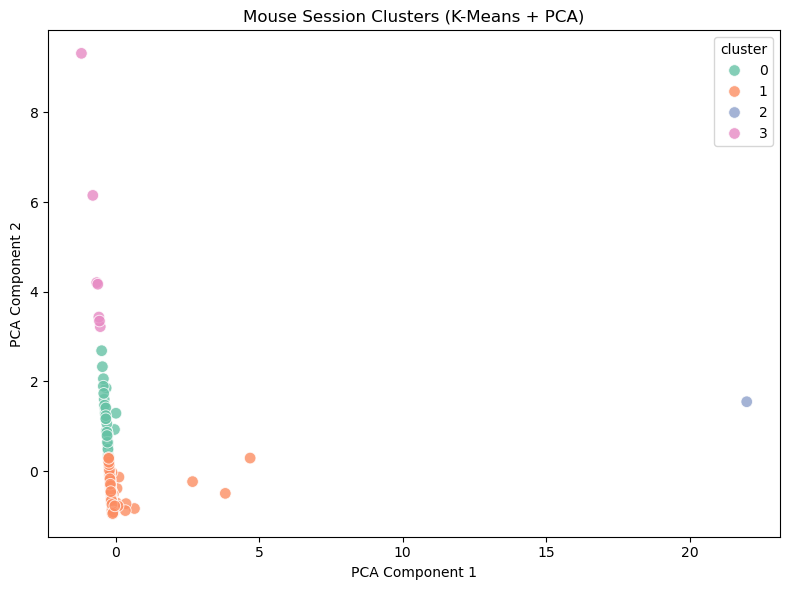

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Define features
features = ['distance_mean', 'distance_std', 'distance_sum',
            'speed_mean', 'speed_std', 'event_count',
            'idle_mean', 'idle_std', 'idle_max', 'session_duration_sec']

# Step 2: Drop rows with any problematic values
X_mouse_clean = mouse_features[features].replace([np.inf, -np.inf], np.nan).dropna()

# Step 3: Sync main DataFrame to cleaned one
mouse_features_clean = mouse_features.loc[X_mouse_clean.index].reset_index(drop=True)
X_mouse_clean = X_mouse_clean.reset_index(drop=True)

# Step 4: Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_mouse_clean)

# Step 5: KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
mouse_features_clean['cluster'] = kmeans.fit_predict(X_scaled)

# Step 6: PCA for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 7: Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=mouse_features_clean['cluster'], palette='Set2', s=70, alpha=0.8)
plt.title("Mouse Session Clusters (K-Means + PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.savefig("mouse_clusters.png", dpi=300)
plt.savefig("mouse_clusters.pdf")
plt.show()


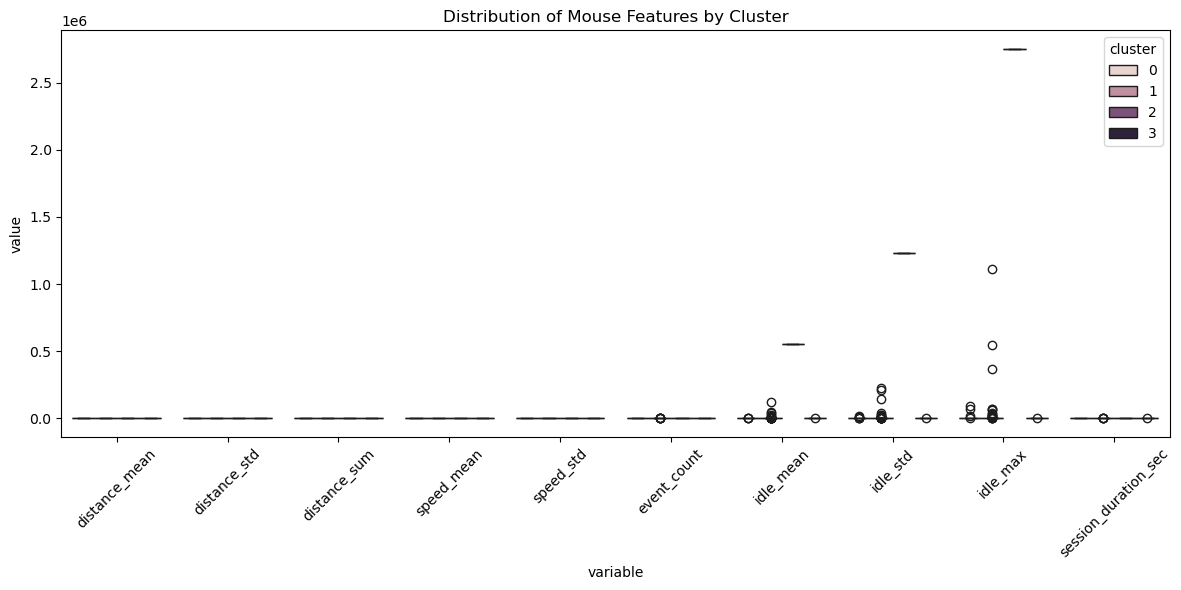

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt for easier plotting
melted = mouse_features_clean.melt(id_vars='cluster', value_vars=features)

plt.figure(figsize=(12, 6))
sns.boxplot(data=melted, x='variable', y='value', hue='cluster')
plt.title("Distribution of Mouse Features by Cluster")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("mouse_cluster_boxplot.pdf")
plt.show()


In [13]:
user_mouse_features = mouse_features_clean.groupby('user_id')[features].agg(['mean', 'std', 'min', 'max']).reset_index()
user_mouse_features.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in user_mouse_features.columns]
user_mouse_features.head()


,user_id_,distance_mean_mean,distance_mean_std,distance_mean_min,distance_mean_max,distance_std_mean,distance_std_std,distance_std_min,distance_std_max,distance_sum_mean,...,idle_std_min,idle_std_max,idle_max_mean,idle_max_std,idle_max_min,idle_max_max,session_duration_sec_mean,session_duration_sec_std,session_duration_sec_min,session_duration_sec_max
0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,51.687673,4.206364e+04,7236.207558,1.860853e+04,215.782,72860.884,95.892474,75.562163,9.058,281.847
1,4.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,6.973136,6.973136e+00,21.733000,NaN,21.733,21.733,45.100000,NaN,45.100,45.100
2,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,764.092509,1.230829e+06,674556.126200,1.183771e+06,1332.485,2752238.615,60.121600,58.162150,9.043,149.369
3,21.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,13.843737,1.384374e+01,20.688000,NaN,20.688,20.688,21.798000,NaN,21.798,21.798
4,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.028607,2.272582e+05,494332.466667,5.670388e+05,6.773,1113334.802,23.604667,13.075519,14.221,38.540
